# Make npz

In [1]:
import pandas as pd
import nrrd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 
from scipy.signal import correlate2d

In [2]:
excel_path = '../../data/dataset_lung.xlsx' 
data = pd.read_excel(excel_path)

In [3]:
# Initialize arrays to store data
full_slices = []
nodules = []
labels = []

In [4]:
# Directory containing the images
image_dir = '../../data/train'  # Replace with your directory name

# Iterate through the rows of the Excel file
for _, row in data.iterrows():
    full_slice_path = os.path.join(image_dir, row['Full_slice'])
    nodule_path = os.path.join(image_dir, row['Nodule'])
    label = row['TumorClass']
    
    # Read the .nrrd files
    full_slice_data, _ = nrrd.read(full_slice_path)
    nodule_data, _ = nrrd.read(nodule_path)
    
    # Append data
    full_slices.append(full_slice_data)
    nodules.append(nodule_data)
    labels.append(label)

In [5]:
print("First 1 element of full_slices:")
print(full_slices[0])

print("\nFirst 1 element of nodules:")
print(nodules[0])

print("\nFirst 10 elements of labels:")
print(labels[:10])

First 1 element of full_slices:
[[-2048 -2048 -2048 ... -2048 -2048 -2048]
 [-2048 -2048 -2048 ... -2048 -2048 -2048]
 [-2048 -2048 -2048 ... -2048 -2048 -2048]
 ...
 [-2048 -2048 -2048 ... -2048 -2048 -2048]
 [-2048 -2048 -2048 ... -2048 -2048 -2048]
 [-2048 -2048 -2048 ... -2048 -2048 -2048]]

First 1 element of nodules:
[[ 470  445  432 ... -920 -910 -874]
 [ 462  447  446 ... -917 -898 -875]
 [ 466  445  430 ... -913 -900 -862]
 ...
 [  53   37   66 ...  -94  -76  -51]
 [  61   54   70 ...  -93 -102  -68]
 [  34   39   37 ...  -99  -88 -131]]

First 10 elements of labels:
[5, 5, 2, 5, 4, 4, 2, 3, 3, 2]


## Resize nodule images

In [6]:
target_shape = (138, 138)

### Resize with interpolation

In [7]:
def interpolate_image(image, target_shape):
    return cv2.resize(image, target_shape, interpolation=cv2.INTER_AREA)

In [8]:
nodules_interpolated = [interpolate_image(image, target_shape) for image in nodules]

In [9]:
# Save in compressed npz
np.savez_compressed('lung_dataset_interpolated.npz', full_slices=full_slices, nodules=nodules_interpolated, tumor_classes=labels)

### Resize it with black padding

In [10]:
def pad_image(image, target_shape):
    """
    Pads an image to the target shape with black borders.
    """
    current_rows, current_cols = image.shape
    pad_top = (target_shape[0] - current_rows) // 2
    pad_bottom = target_shape[0] - current_rows - pad_top
    pad_left = (target_shape[1] - current_cols) // 2
    pad_right = target_shape[1] - current_cols - pad_left
    return np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)

In [11]:
nodules_padded = [pad_image(image, target_shape) for image in nodules_interpolated]

In [12]:
np.savez_compressed('lung_dataset_padded.npz', full_slices=full_slices, nodules=nodules_padded, tumor_classes=labels)

## Only save the box of the nodule

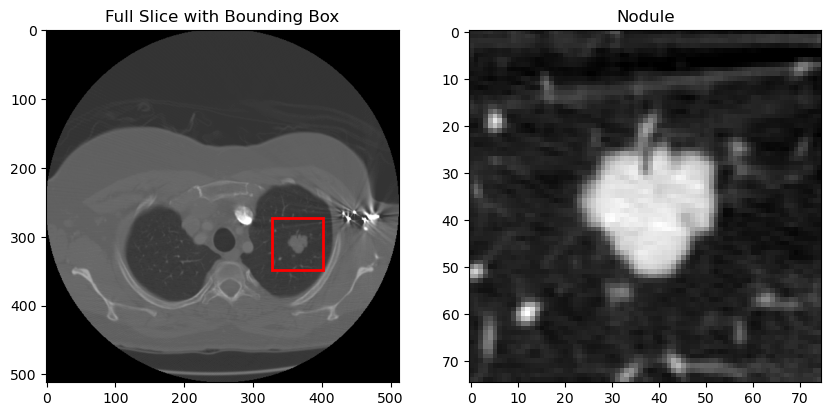

In [13]:
import cv2
import numpy as np

def preprocess_edges(image, method='canny', low_threshold=50, high_threshold=150):
    """
    Preprocesses the image to extract edges using the specified method.
    
    Args:
        image (ndarray): The input image.
        method (str): Edge detection method ('canny' or 'sobel').
        low_threshold (int): Lower threshold for Canny edge detection.
        high_threshold (int): Upper threshold for Canny edge detection.
    
    Returns:
        ndarray: Binary edge-detected image.
    """
    if method == 'canny':
        edges = cv2.Canny(image.astype(np.uint8), low_threshold, high_threshold)
    elif method == 'sobel':
        # Apply Sobel operator for edge detection
        grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        edges = cv2.magnitude(grad_x, grad_y).astype(np.uint8)
    else:
        raise ValueError("Invalid method. Choose 'canny' or 'sobel'.")
    
    return edges

def find_bounding_box_with_edges(full_image, nodule_image, edge_method='canny'):
    """
    Finds the bounding box of the nodule in the full image using edge-based template matching.
    
    Args:
        full_image (ndarray): Full image.
        nodule_image (ndarray): Zoomed-in nodule image.
        edge_method (str): Edge detection method ('canny' or 'sobel').
    
    Returns:
        tuple: Bounding box (x, y, w, h).
    """
    # Extract edges from both images
    full_edges = preprocess_edges(full_image, method=edge_method)
    nodule_edges = preprocess_edges(nodule_image, method=edge_method)
    
    # Perform template matching on edge images
    result = cv2.matchTemplate(full_edges, nodule_edges, method=cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    
    # Top-left corner of the best match
    top_left_x, top_left_y = max_loc
    
    # Width and height of the nodule
    h, w = nodule_image.shape
    
    # Return the bounding box as (x, y, w, h)
    return top_left_x, top_left_y, w, h


# Example usage
nodule_index = 60  # Replace with the index of the nodule you want to find
full_slice = full_slices[nodule_index]
nodule = nodules[nodule_index]

x, y, w, h = find_bounding_box_with_edges(full_slice, nodule)

# Plot the full slice with the bounding box
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(full_slice, cmap='gray')
plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2))
plt.title('Full Slice with Bounding Box')

# Plot the nodule
plt.subplot(1, 2, 2)
plt.imshow(nodule, cmap='gray')
plt.title('Nodule')

plt.show()

In [14]:
# Find the bounding boxes for all nodules
bounding_boxes = [find_bounding_box_with_edges(full_slice, nodule) for full_slice, nodule in zip(full_slices, nodules)]

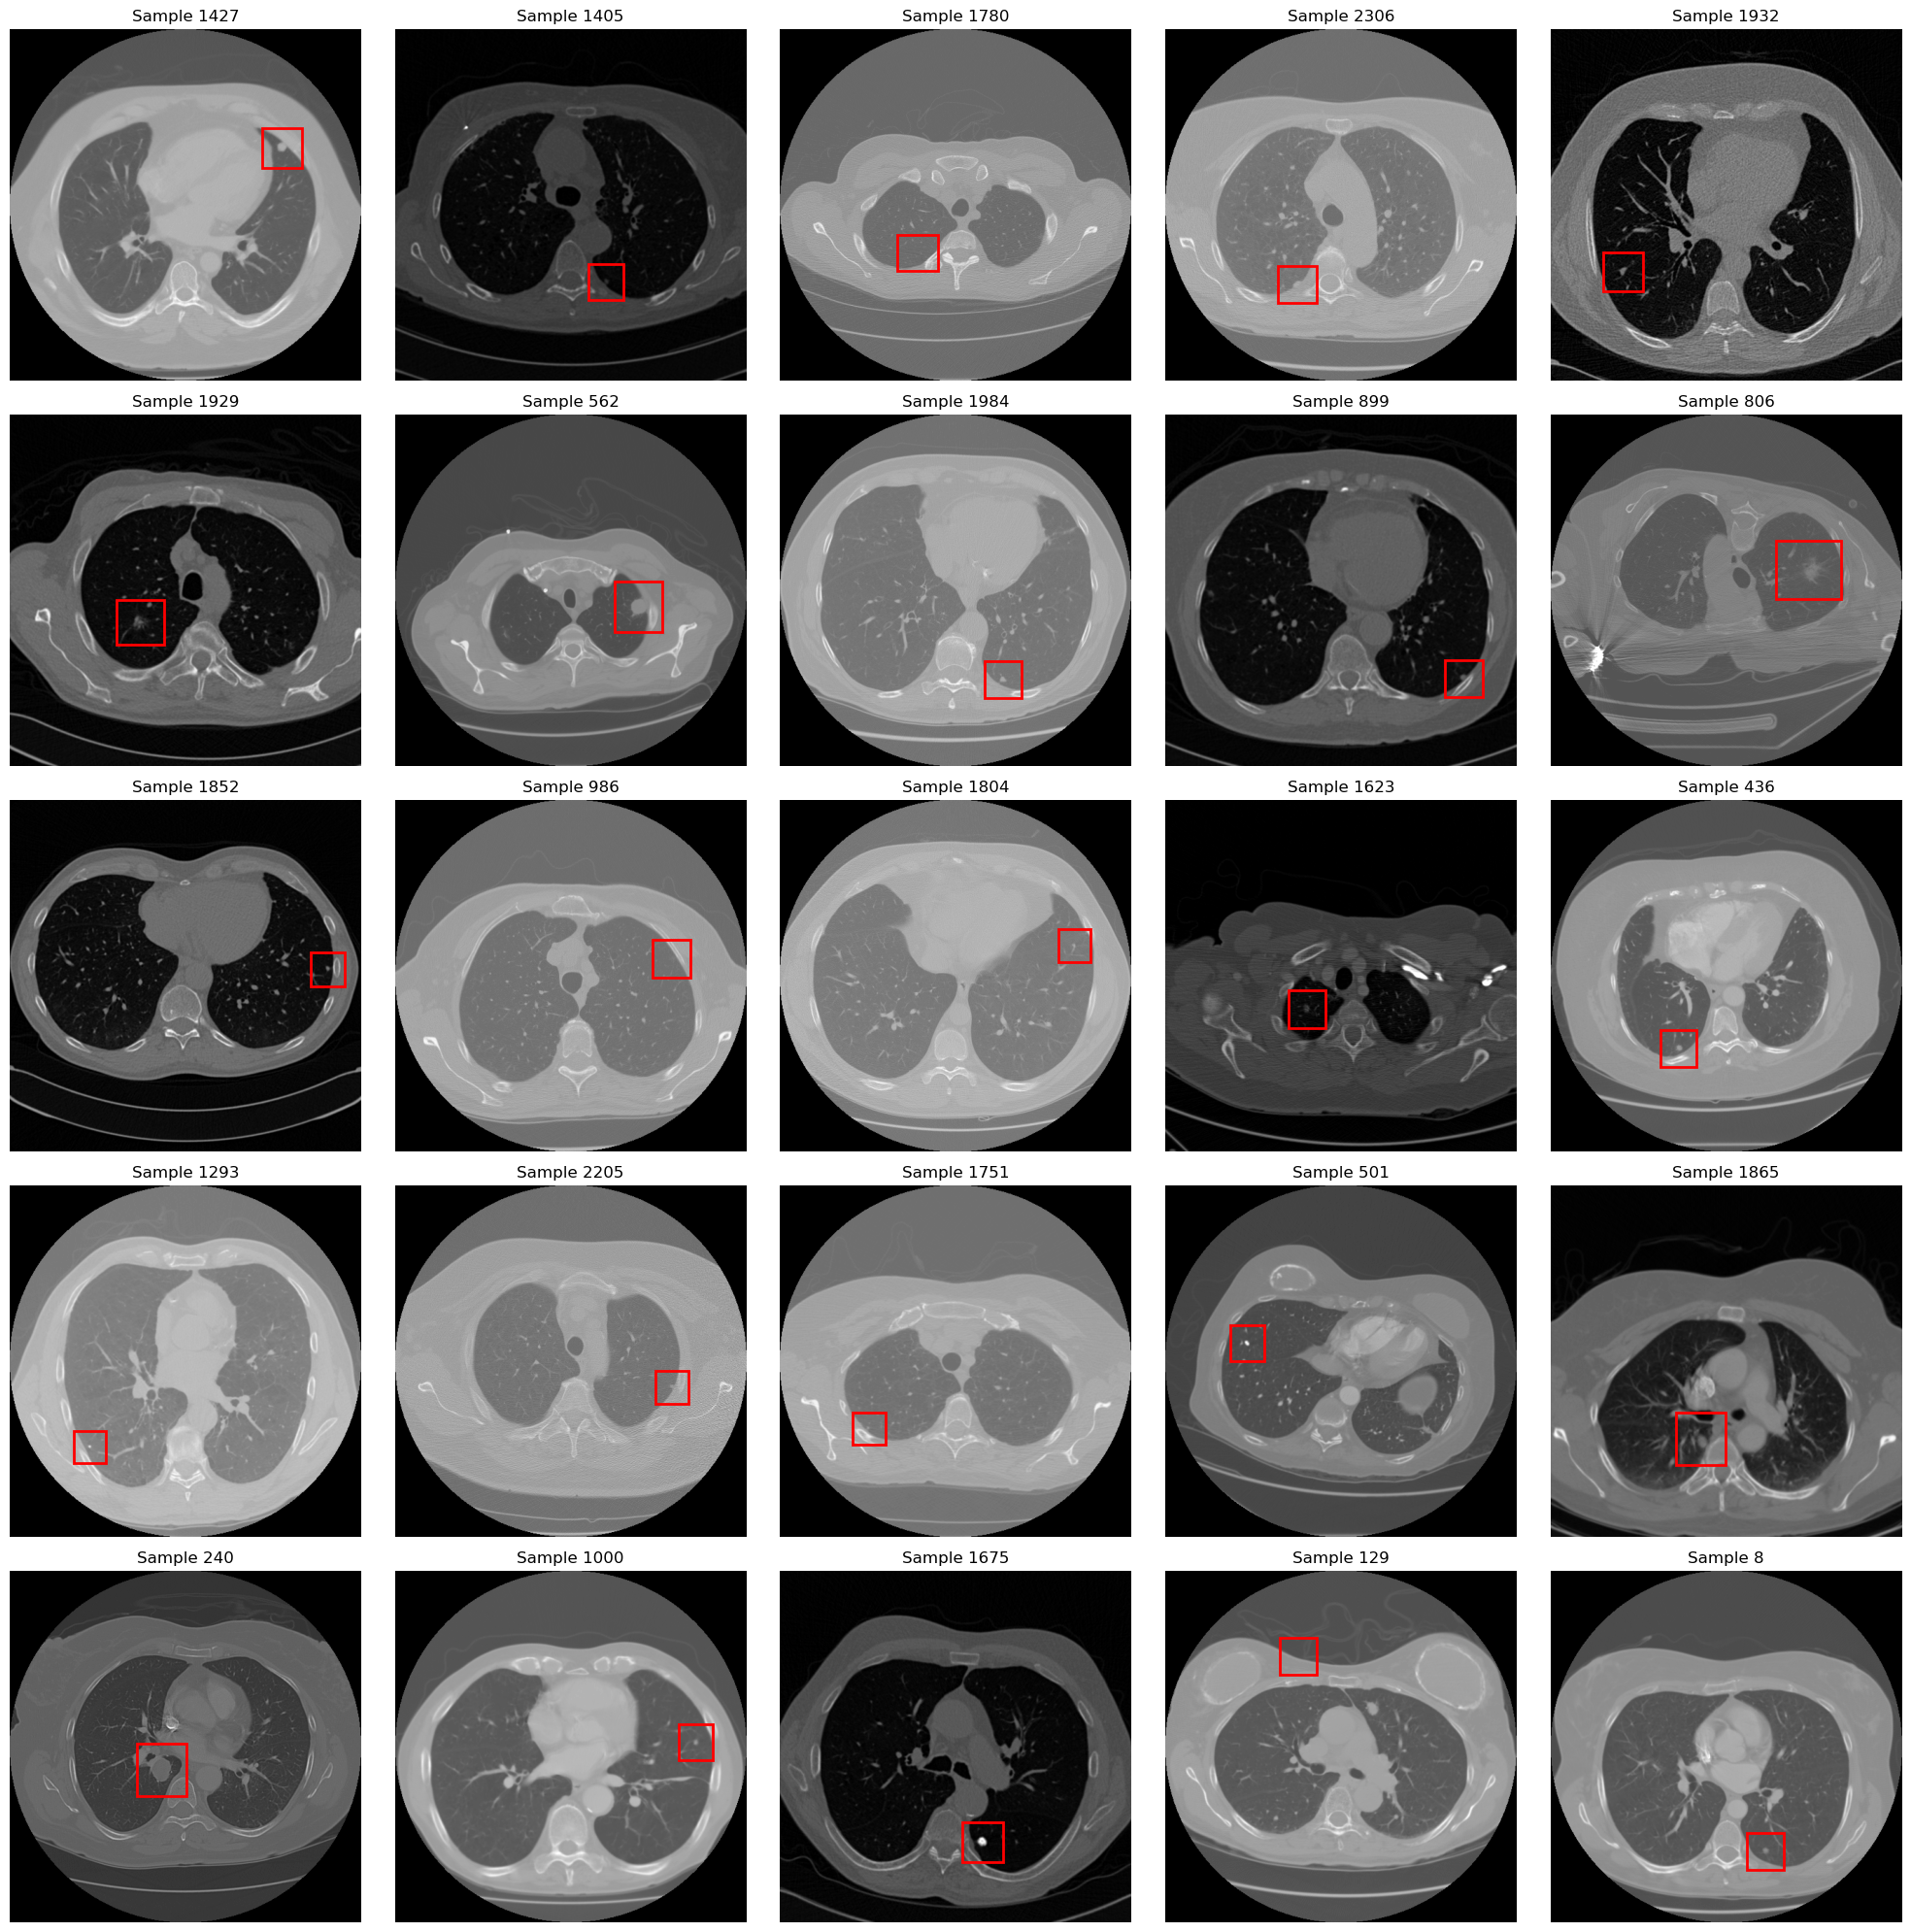

In [15]:
import random

# Pick 25 random indices
random_indices = random.sample(range(len(full_slices)), 24)
random_indices.append(8)

# Plot the full slices with bounding boxes
plt.figure(figsize=(20, 20))
for i, idx in enumerate(random_indices):
    full_slice = full_slices[idx]
    x, y, w, h = bounding_boxes[idx]
    
    plt.subplot(5, 5, i + 1)
    plt.imshow(full_slice, cmap='gray')
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2))
    plt.title(f'Sample {idx}')
    plt.axis('off')

plt.tight_layout()
plt.show()

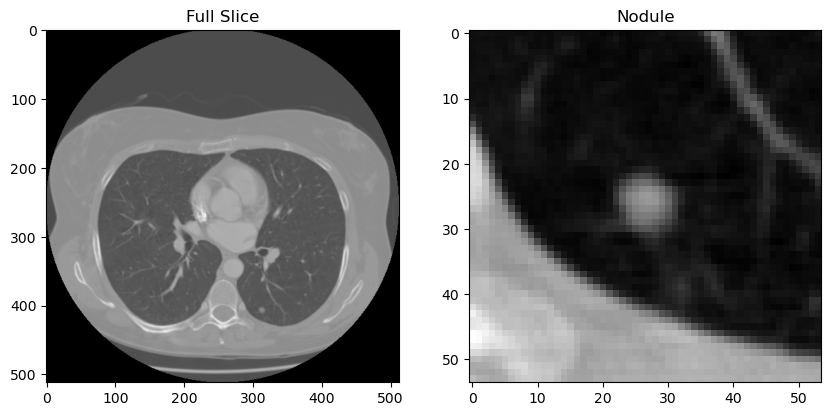

In [16]:
index = 8
full_slice = full_slices[index]
nodule = nodules[index]

plt.figure(figsize=(10, 5))

# Plot the full slice
plt.subplot(1, 2, 1)
plt.imshow(full_slice, cmap='gray')
plt.title('Full Slice')

# Plot the nodule
plt.subplot(1, 2, 2)
plt.imshow(nodule, cmap='gray')
plt.title('Nodule')

plt.show()

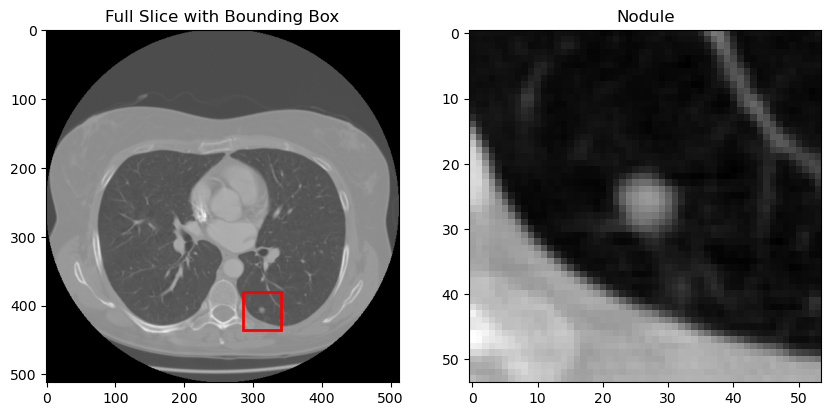

In [18]:
# Use the find_bounding_box algorithm on the full slice of index 8
index = 8
full_slice = full_slices[index]
nodule = nodules[index]

x, y, w, h = find_bounding_box_with_edges(full_slice, nodule)

# Plot the full slice with the bounding box
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(full_slice, cmap='gray')
plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2))
plt.title('Full Slice with Bounding Box')

# Plot the nodule
plt.subplot(1, 2, 2)
plt.imshow(nodule, cmap='gray')
plt.title('Nodule')

plt.show()

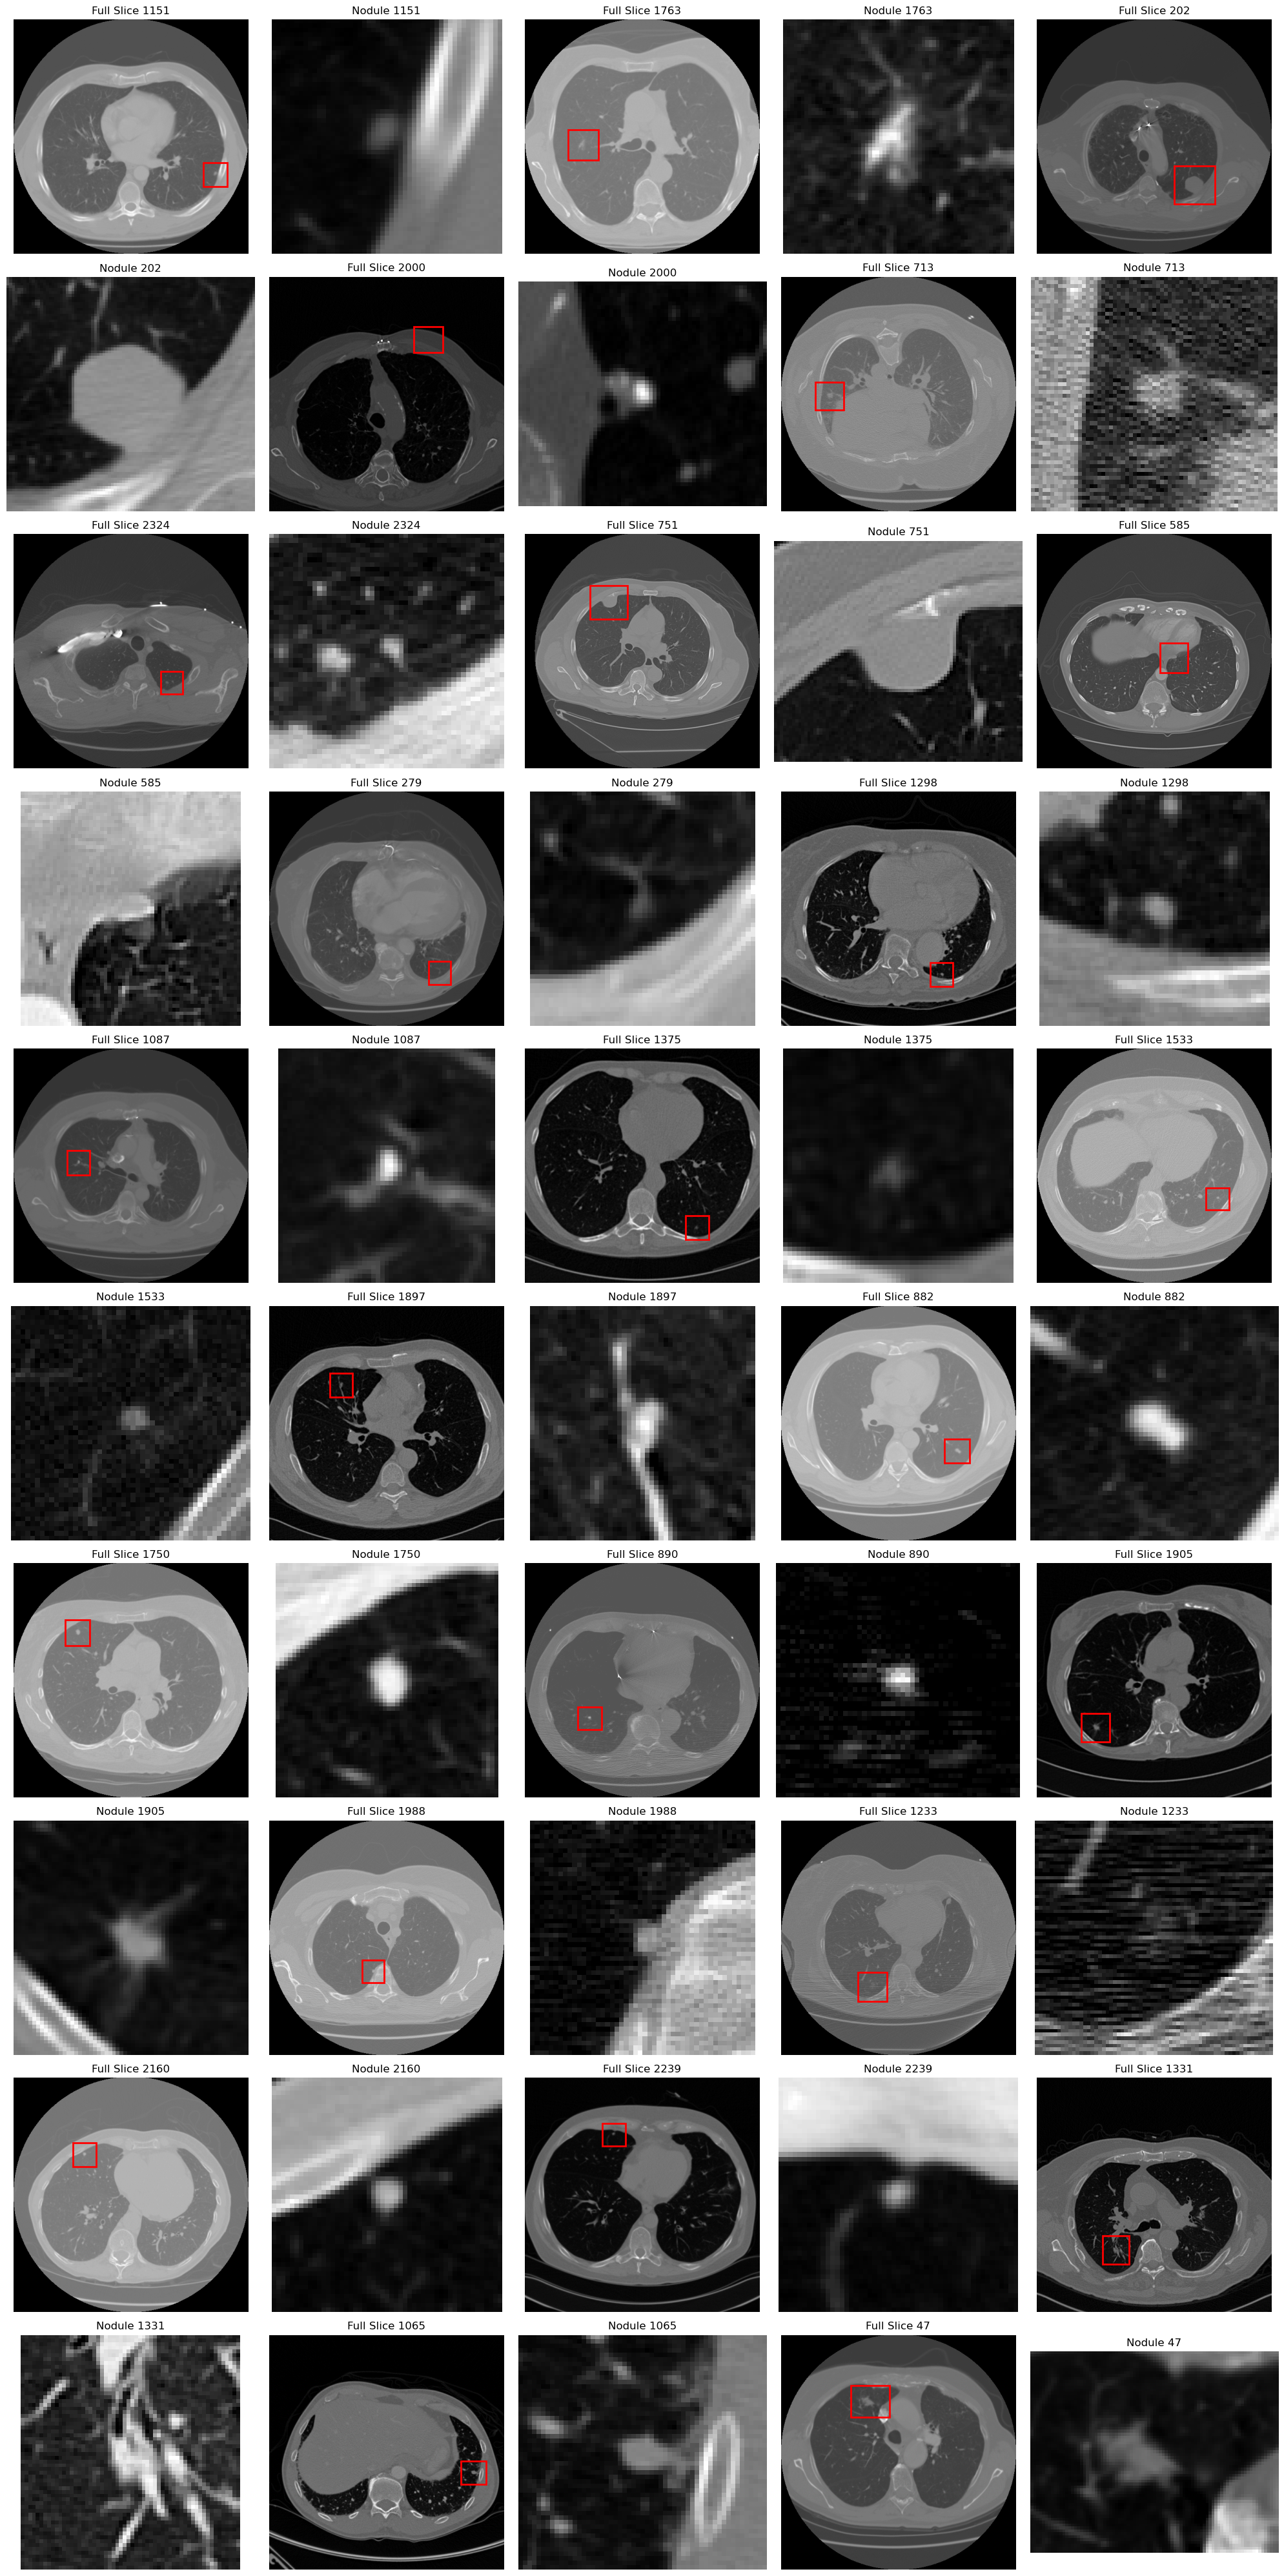

In [17]:
# Pick 25 random indices
random_indices = random.sample(range(len(full_slices)), 25)

# Plot the full slices with bounding boxes and nodules side by side
plt.figure(figsize=(20, 40))
for i, idx in enumerate(random_indices):
    full_slice = full_slices[idx]
    nodule = nodules[idx]
    x, y, w, h = bounding_boxes[idx]
    
    plt.subplot(10, 5, 2 * i + 1)
    plt.imshow(full_slice, cmap='gray')
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2))
    plt.title(f'Full Slice {idx}')
    plt.axis('off')
    
    plt.subplot(10, 5, 2 * i + 2)
    plt.imshow(nodule, cmap='gray')
    plt.title(f'Nodule {idx}')
    plt.axis('off')

plt.tight_layout()
plt.show()


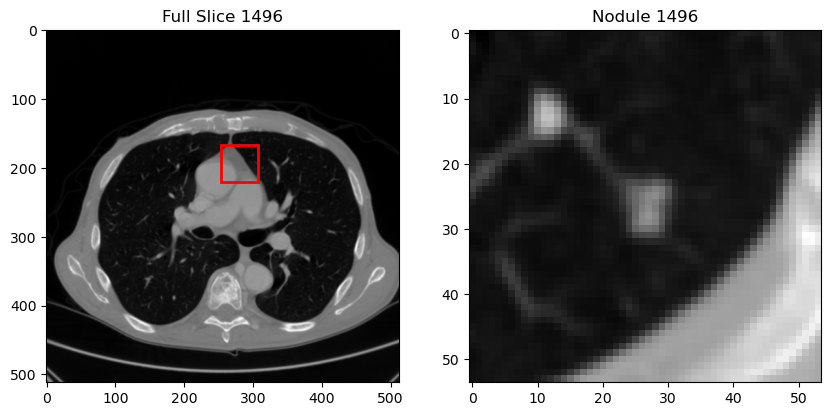

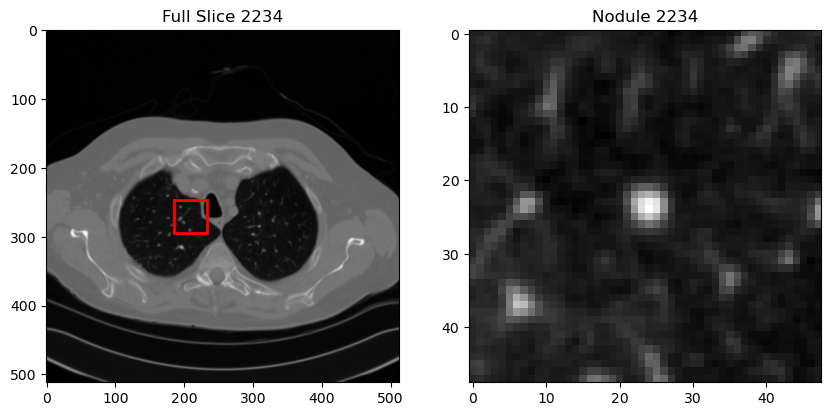

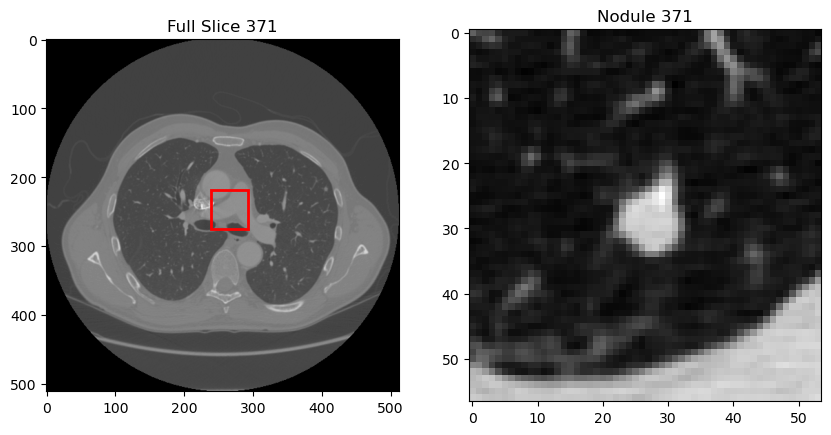

In [18]:
specific_indices = [1496, 2234, 371]

for idx in specific_indices:
    full_slice = full_slices[idx]
    x, y, w, h = bounding_boxes[idx]
    
    plt.figure(figsize=(10, 5))
    
    # Plot the full slice with the bounding box
    plt.subplot(1, 2, 1)
    plt.imshow(full_slice, cmap='gray')
    plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', facecolor='none', linewidth=2))
    plt.title(f'Full Slice {idx}')
    
    # Plot the nodule
    plt.subplot(1, 2, 2)
    plt.imshow(nodules[idx], cmap='gray')
    plt.title(f'Nodule {idx}')
    
    plt.show()

In [19]:
np.savez_compressed('lung_dataset_bounding_boxes.npz', full_slices=full_slices, nodules_boxes=bounding_boxes, tumor_classes=labels)